In [1]:
import pandas as pd
import _preprocessing
import importlib
importlib.reload(_preprocessing)
prices = pd.read_csv('../cryptoCompareData/btc_prices.csv')[['close']]
binary_gen = _preprocessing.LinearCoefficientTargetGenerator(source_column_name='close',regression_for_days_ahead=10,classifier_borders=(0.0,),result_column_name='y_classes')
regression_gen = _preprocessing.LinearCoefficientTargetGenerator(source_column_name='close',regression_for_days_ahead=10,result_column_name='y_regression')

prices = binary_gen.fit_transform(prices)
prices = regression_gen.fit_transform(prices)
prices.head(10)

D:\Egyetem\7.Semester\CryptoPredictions\_preprocessing.py:104: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, _, _, _ = np.linalg.lstsq(x, shifted)


,close,y_classes,y_regression
0,0.04951,1.0,0.001679
1,0.08584,0.0,-0.004249
2,0.08080,0.0,-0.003590
3,0.07474,0.0,-0.002345
4,0.07921,0.0,-0.002973
5,0.05050,1.0,0.001858
6,0.06262,0.0,-0.000031
7,0.05454,1.0,0.001239
8,0.05050,1.0,0.001853
9,0.05600,1.0,0.000832


## binary regression targets (will be tending upwards or downwards)

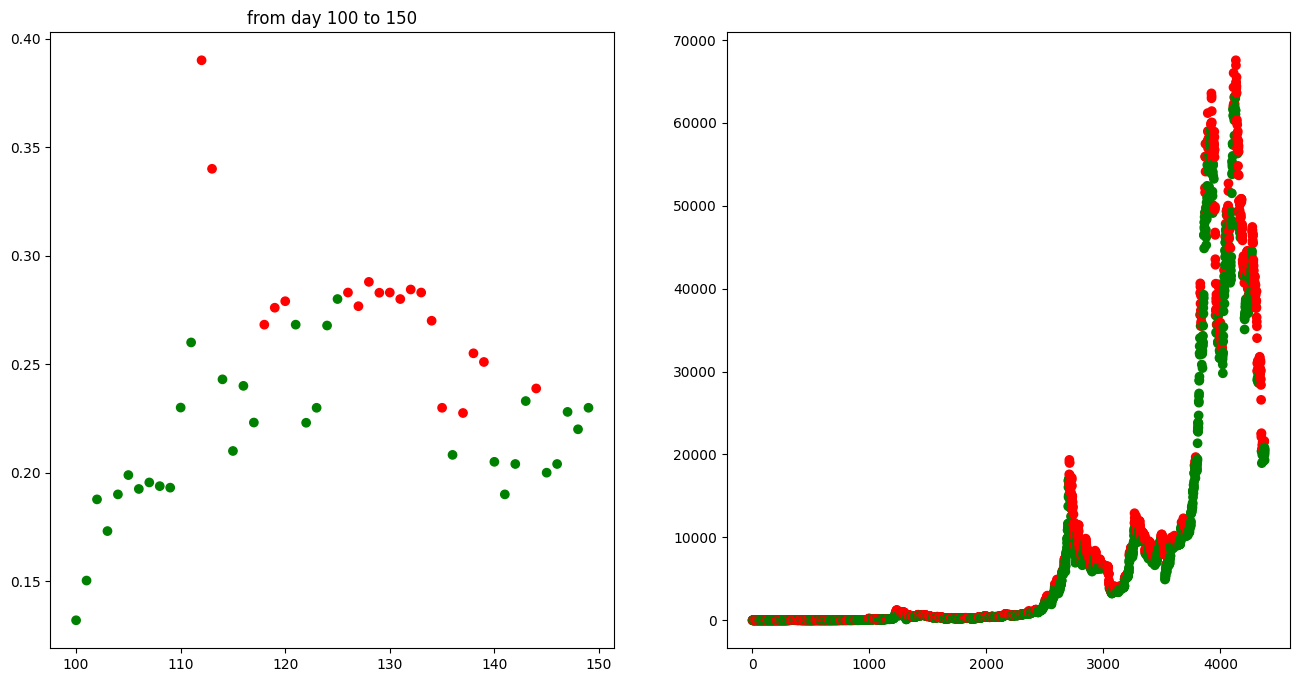

In [2]:
import matplotlib.pyplot as plt
import matplotlib

fig,axes = plt.subplots(ncols=2,figsize=(16,8))

colors = ['red','green']
x = prices.index.tolist()
y = prices.close.values
label = prices.y_classes.values
show_from = 100
show_to = 150#len(x)
axes[0].scatter(x[show_from:show_to], y[show_from:show_to], c=label[show_from:show_to], cmap=matplotlib.colors.ListedColormap(colors))
axes[0].set_title(f'from day {show_from} to {show_to}')
axes[1].scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

## normal regression targets (label is the slope of the regression)

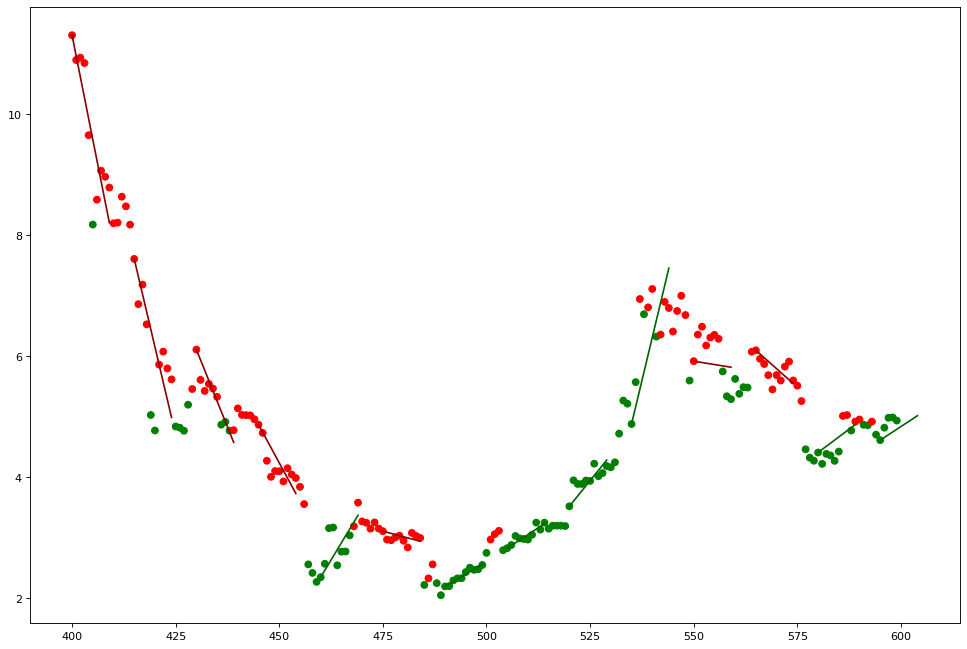

In [3]:
import numpy as np

plt.figure(figsize=(15, 10), dpi=80)

colors = ['red','green']
x = prices.index.tolist()
y = prices.close.values
label = prices.y_classes.values
show_from = 400
show_to = 600
plt.scatter(x[show_from:show_to], y[show_from:show_to], c=label[show_from:show_to], cmap=matplotlib.colors.ListedColormap(colors))

line_at_every = 15

line_starts_values = prices.close.values[show_from::line_at_every]
line_slopes_values = prices.y_regression.values[show_from::line_at_every]

lines = []
line_length = 10

for line_start_idx in np.arange(show_from,show_to,15):
    x_values = np.arange(line_start_idx,line_start_idx+line_length,1)
    y_values = np.array([ prices.close.iloc[line_start_idx] + prices.y_regression.iloc[line_start_idx]*step for step in range(line_length)])

    color = 'darkred' if prices.y_regression.iloc[line_start_idx] < 0 else 'darkgreen'
    plt.plot(x_values, y_values, c = color)

#### To Scaled data

D:\Egyetem\7.Semester\CryptoPredictions\_preprocessing.py:104: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, _, _, _ = np.linalg.lstsq(x, shifted)


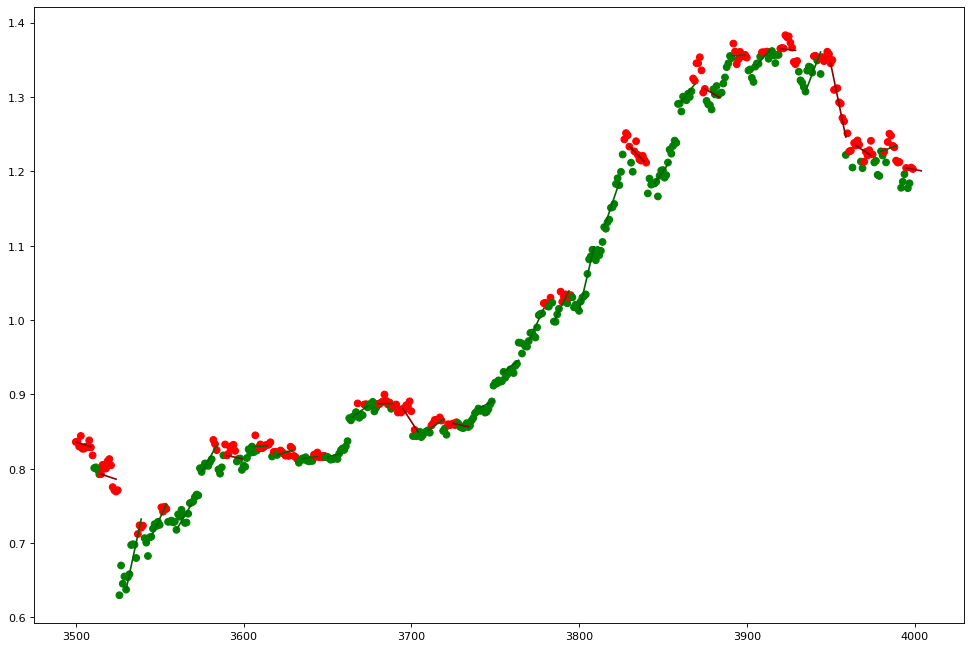

In [4]:
normalized_log = prices.copy(deep=True)
normalized_log['close'] = np.log(normalized_log['close'])
normalized_log = (normalized_log-normalized_log.mean())/normalized_log.std()
normalized_log = regression_gen.fit_transform(normalized_log)

plt.figure(figsize=(15, 10), dpi=80)

colors = ['red','green']
x = normalized_log.index.tolist()
y = normalized_log.close.values
label = normalized_log.y_classes.values
show_from = 3500
show_to = 4000
plt.scatter(x[show_from:show_to], y[show_from:show_to], c=label[show_from:show_to], cmap=matplotlib.colors.ListedColormap(colors))

line_at_every = 15

line_starts_values = normalized_log.close.values[show_from::line_at_every]
line_slopes_values = normalized_log.y_regression.values[show_from::line_at_every]

lines = []
line_length = 10

for line_start_idx in np.arange(show_from,show_to,15):
    x_values = np.arange(line_start_idx,line_start_idx+line_length,1)
    y_values = np.array([ normalized_log.close.iloc[line_start_idx] + normalized_log.y_regression.iloc[line_start_idx]*step for step in range(line_length)])

    color = 'darkred' if normalized_log.y_regression.iloc[line_start_idx] < 0 else 'darkgreen'
    plt.plot(x_values, y_values, c = color)

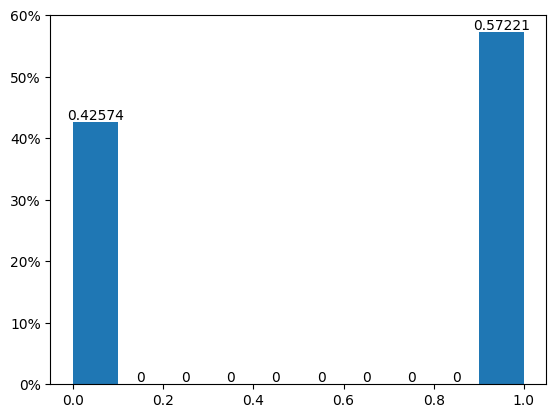

In [5]:
from matplotlib.ticker import PercentFormatter

counts, edges, bars = plt.hist(prices.y_classes, weights=np.ones(len(prices)) / len(prices))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.bar_label(bars);

In [42]:
from models.baselines import LastValuePredictor

reshaped =np.reshape(prices.values,(len(prices),-1,prices.shape[-1]))
predictor_last_value = LastValuePredictor(predict_feature_idx=1)

In [43]:
y_preds_lv = predictor_last_value.predict(reshaped).reshape(-1)
predictables_lv = prices.iloc[1:]
success = len(predictables_lv[predictables_lv.y_classes ==y_preds_lv[:-1]])
success / len(predictables_lv)


0.8484848484848485

In [56]:
import models
import importlib
importlib.reload(models.baselines)
prices_notna = prices.iloc[1:-10]
reshaped_notna=np.reshape(prices_notna.values,(len(prices_notna),-1,prices_notna.shape[-1]))
random_predictor = models.baselines.RandomBinaryPredictor(predict_feature_idx=1,match_distribution=True)
y_preds_binary = random_predictor.predict(reshaped_notna)
predictables_binary = prices_notna
success_binary = len(predictables_binary[predictables_binary.y_classes ==y_preds_binary])
success_binary / len(predictables_binary)

0.5065083352363553